In [1]:
import os
import sys
from IPython.display import Image
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
from optuna.trial import create_trial
from optuna.distributions import CategoricalDistribution, IntUniformDistribution, LogUniformDistribution

sys.path.append(os.path.join(os.getcwd(), "../")) 
from results import log_best_model

In [2]:
# Setting up the tracking_uri and the experiment name
mlflow.set_tracking_uri("../../outputs/experiments/mlruns")
mlflow.set_experiment(experiment_name='mapintel-experiment-v1')

In [3]:
# Querying the runs
df_results = mlflow.search_runs()
df_results.shape

Traceback (most recent call last):
  File "/home/dsilva/miniconda3/envs/mapintel_experiments/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 699, in _list_run_infos
    run_info = self._get_run_info_from_dir(r_dir)
  File "/home/dsilva/miniconda3/envs/mapintel_experiments/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 529, in _get_run_info_from_dir
    meta = read_yaml(run_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dsilva/miniconda3/envs/mapintel_experiments/lib/python3.9/site-packages/mlflow/utils/file_utils.py", line 170, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '../../outputs/experiments/mlruns/1/.trash/meta.yaml' does not exist.


(100, 75)

In [4]:
# Compute umap_avgknn_acc_test_mean (if needed)
if 'metrics.umap_avgknn_acc_test_mean' not in df_results.columns:
    df_results['metrics.umap_avgknn_acc_test_mean'] = \
    np.mean([df_results[f'metrics.umap_{k}nn_acc_test_mean'] for k in [10, 20, 40, 80, 160]], axis=0)

# Compute minmax_avg
df_results['metrics.minmax_avg'] = np.mean(MinMaxScaler().fit_transform(df_results[['metrics.nmi_test_mean', 'metrics.topic_coherence_c_v_mean', 'metrics.umap_avgknn_acc_test_mean']]), axis=1)

# Compute total_infer_time
df_results['metrics.timer_total_infer_mean'] = np.sum(df_results[['metrics.timer_emb_model_infer_mean', 'metrics.timer_top_model_infer_mean']], axis=1)

# Selecting columns to analyze
df_results = df_results[['run_id', 'experiment_id', 'start_time', 'artifact_uri', 
                         # metrics
                         'metrics.minmax_avg', 'metrics.nmi_test_mean', 
                         'metrics.topic_coherence_c_v_mean', 'metrics.umap_avgknn_acc_test_mean', 
                         'metrics.topic_diversity_mean', 'metrics.timer_total_infer_mean',
                         # params
                         'params.n_neighbors', 'params.max_iter', 'params.embedding_model', 
                         'params.n_components', 'params.topic_model', 'params.metric', 'params.dm', 
                         'params.cv-folds', 'params.learning_decay', 'params.max_doc_update_iter', 
                         'params.hidden_sizes', 'params.dropout', 'params.activation', 
                         'params.inference_type', 'params.num_epochs', 'params.model_type', 'params.lr', 
                         'params.cluster_selection_epsilon', 'params.min_topic_size', 
                         'params.min_cluster_size', 'params.cluster_selection_method']]

In [5]:
# Display top 10 results
df_results = df_results.sort_values(by=['metrics.nmi_test_mean', 'metrics.topic_coherence_c_v_mean', 'metrics.umap_avgknn_acc_test_mean'], ascending=False)
df_results.head(10).T

,44,88,75,8,9,80,70,30,13,42
run_id,6c70ea4b968f4267a1468252c0efa3ee,410ddfd0f9e84f11b90fcb30bc1fd8e7,6dcbc20f72b24fa59f63129e9d13cd61,71d158566a5d43d1a6a44111e14cf292,6f188aeeb93748f88e721a65a83d118e,f11cc7d580c54d33a83b714c0729e2c2,20d97a441b054e12ba65b4336d140d67,d9c33d95be79432ea5aeaa0ae222489c,b2bc5c50dcc341928547b1a76a63c9ce,f984efb617d248cba802c38904d93968
experiment_id,1,1,1,1,1,1,1,1,1,1
start_time,2021-12-03 03:10:29.534000+00:00,2021-12-01 06:20:11.551000+00:00,2021-12-01 19:35:16.729000+00:00,2021-12-04 20:06:28.494000+00:00,2021-12-04 19:47:11.228000+00:00,2021-12-01 17:00:03.714000+00:00,2021-12-01 22:30:57.762000+00:00,2021-12-03 12:43:41.152000+00:00,2021-12-04 14:49:30.565000+00:00,2021-12-03 03:47:18.236000+00:00
artifact_uri,/home/dsilva/projects/mapintel/experiments/../...,/home/dsilva/projects/mapintel/experiments/../...,/home/dsilva/projects/mapintel/experiments/../...,/home/dsilva/projects/mapintel/experiments/../...,/home/dsilva/projects/mapintel/experiments/../...,/home/dsilva/projects/mapintel/experiments/../...,/home/dsilva/projects/mapintel/experiments/../...,/home/dsilva/projects/mapintel/experiments/../...,/home/dsilva/projects/mapintel/experiments/../...,/home/dsilva/projects/mapintel/experiments/../...
metrics.minmax_avg,0.870493,0.88339,0.942027,0.912004,0.927695,0.588635,0.703845,0.677709,0.52629,0.513242
metrics.nmi_test_mean,0.403374,0.374233,0.362758,0.357663,0.344467,0.330134,0.328578,0.301361,0.287471,0.272917
metrics.topic_coherence_c_v_mean,0.683588,0.752861,0.758729,0.761128,0.75985,0.367578,0.576081,0.528268,0.542882,0.566994
metrics.umap_avgknn_acc_test_mean,0.306803,0.295559,0.358676,0.331575,0.358676,0.306196,0.277473,0.306803,0.158775,0.141164
metrics.topic_diversity_mean,0.87441,0.87975,0.879028,0.892,0.881905,0.98,0.935,0.868,0.824,0.81
metrics.timer_total_infer_mean,43.505045,43.401981,43.099112,44.802651,44.88891,46.342017,41.171708,43.975593,45.020608,43.265749


In [6]:
print("The run with highest minmax_avg has index", df_results['metrics.minmax_avg'].argmax())

The run with highest minmax_avg has index 2


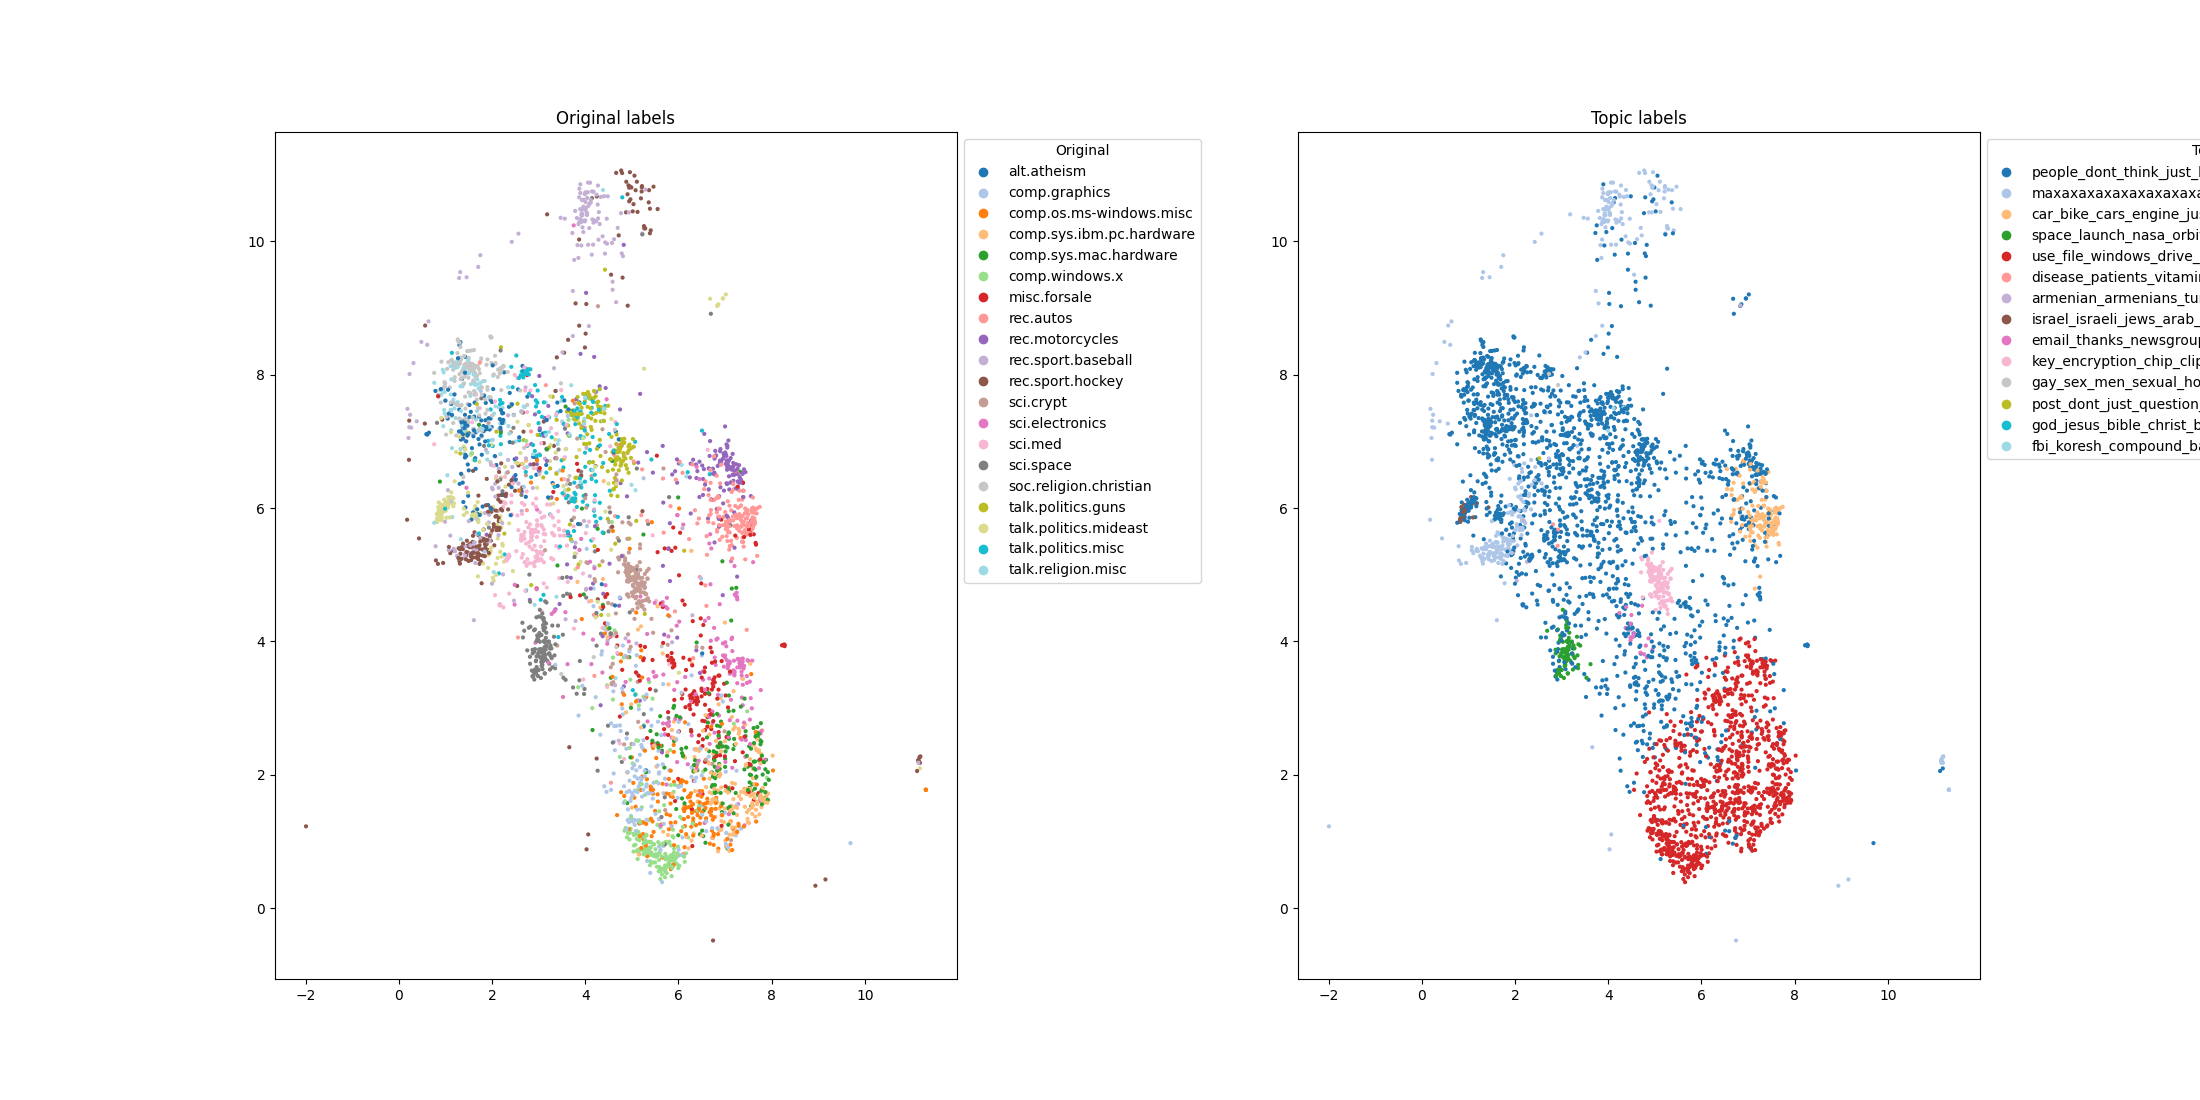

In [7]:
# Visualize artifacts from top 1 run
Image(os.path.join(df_results.iloc[0]['artifact_uri'], 'umap_test_plot.png'))

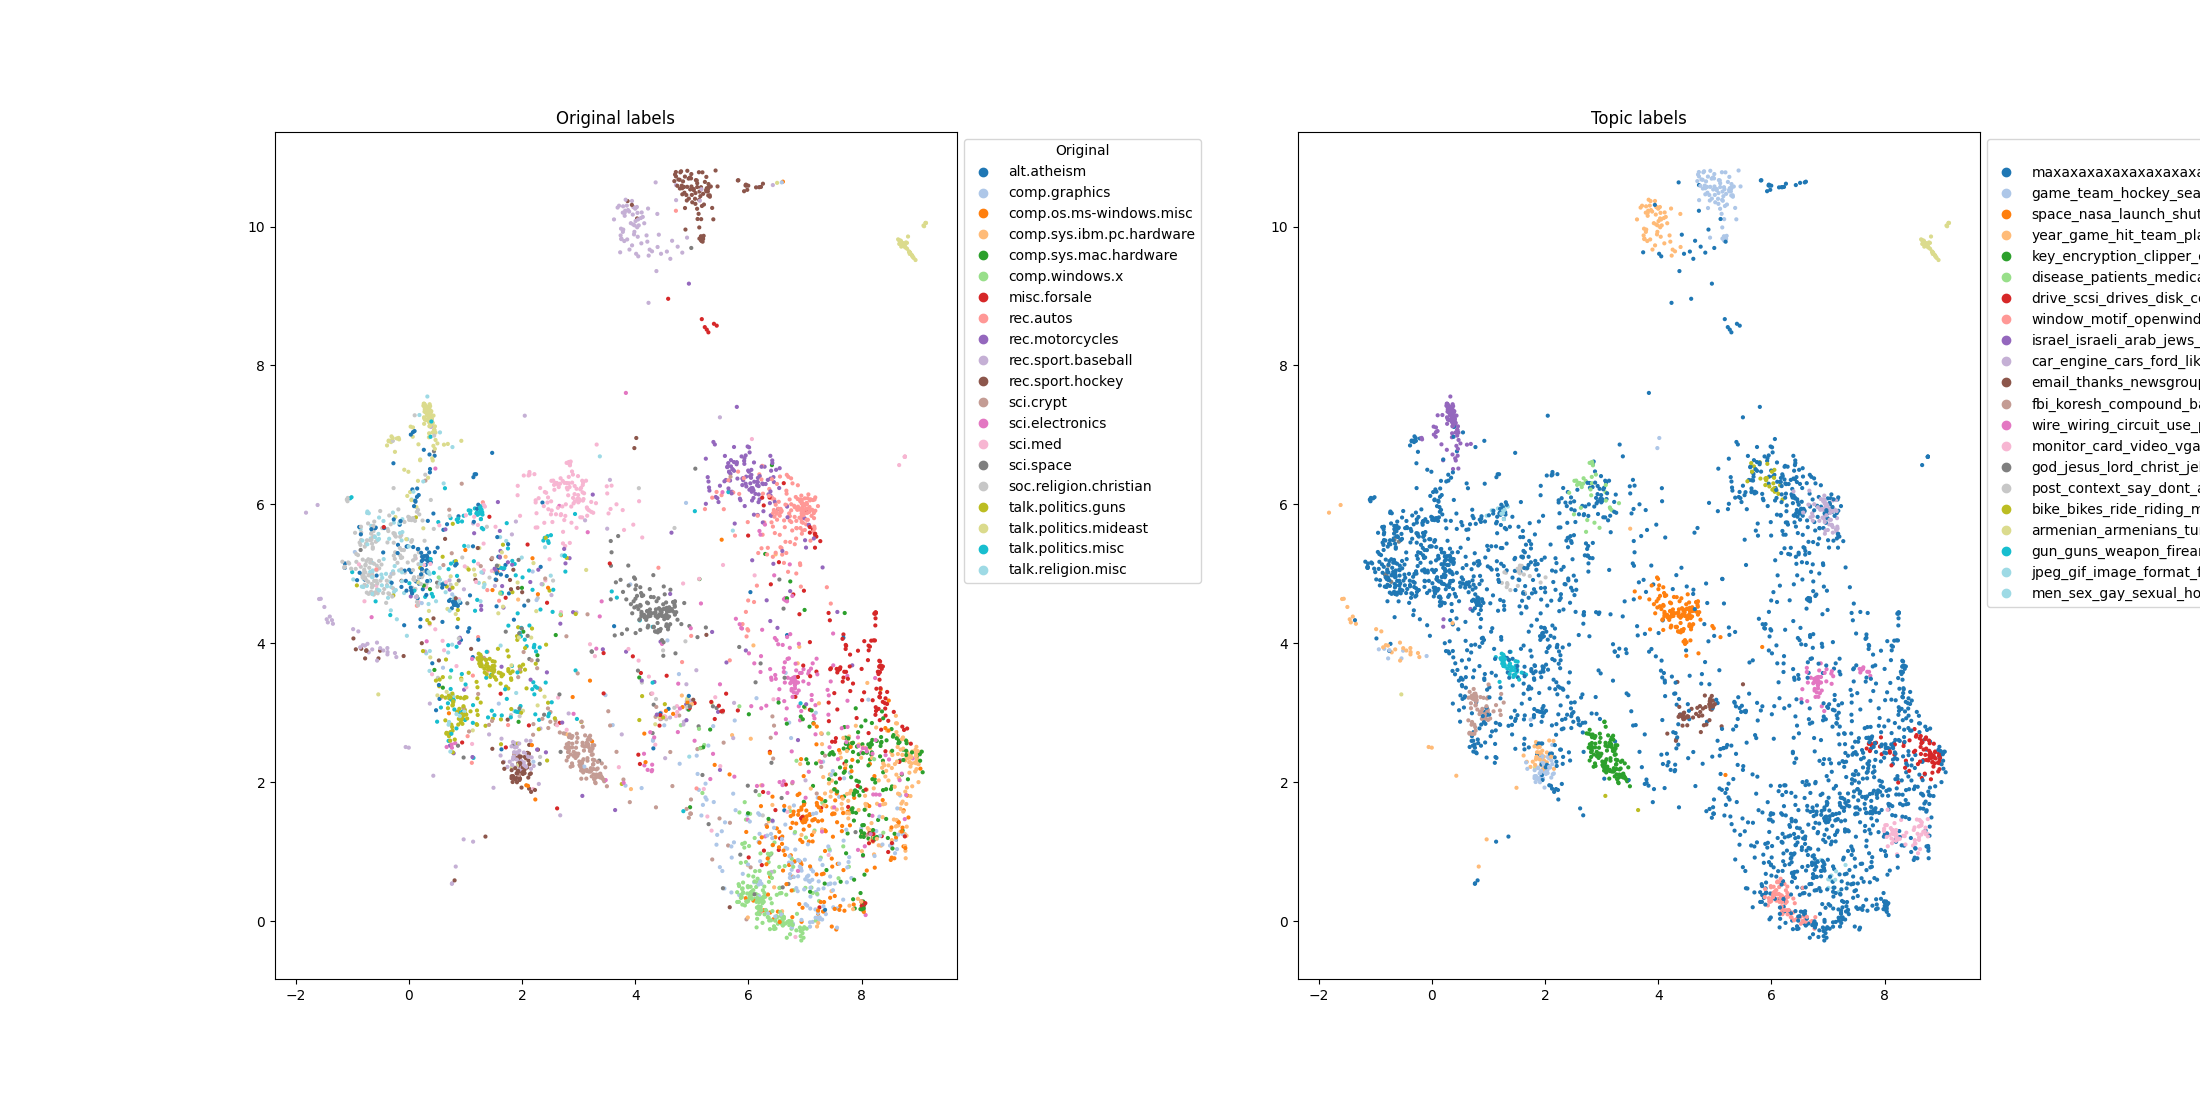

In [8]:
# Visualize artifacts from highest minmax_avg
top_result = df_results.iloc[df_results['metrics.minmax_avg'].argmax()]
Image(os.path.join(top_result['artifact_uri'], 'umap_test_plot.png'))

Traceback (most recent call last):
  File "/home/dsilva/miniconda3/envs/mapintel_experiments/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 699, in _list_run_infos
    run_info = self._get_run_info_from_dir(r_dir)
  File "/home/dsilva/miniconda3/envs/mapintel_experiments/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 529, in _get_run_info_from_dir
    meta = read_yaml(run_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dsilva/miniconda3/envs/mapintel_experiments/lib/python3.9/site-packages/mlflow/utils/file_utils.py", line 170, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '../../outputs/experiments/mlruns/1/.trash/meta.yaml' does not exist.
<ipython-input-9-bafeb259a6d5>:20: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  best_trial = create_trial(


Load and clean the dataset.
Suggest hyperparameters.
{
  "embedding_model": "sentence-transformers/msmarco-distilbert-base-v4",
  "umap_args__n_neighbors": 14,
  "umap_args__n_components": 10,
  "umap_args__metric": "cosine",
  "topic_model": "BERTopic",
  "min_topic_size": 33,
  "hdbscan_args__min_cluster_size": 110,
  "hdbscan_args__cluster_selection_epsilon": 0.05516517617078291,
  "hdbscan_args__cluster_selection_method": "leaf"
}
Define the embedding model.
Define the topic model.
Fit and transform the SentenceTransformer embedding model.


Batches:   0%|          | 0/454 [00:00<?, ?it/s]

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

Fit and transform the BERTopic topic model.
Reduce embeddings to 2 dimensions with UMAP.
Evaluate UMAP on K-NN accuracy.
Evaluate clustering on Mutual Information.
Evaluate topics on Diversity and Coherence metrics.
Produce UMAP plot: Original labels VS Topics.
Log artifacts.


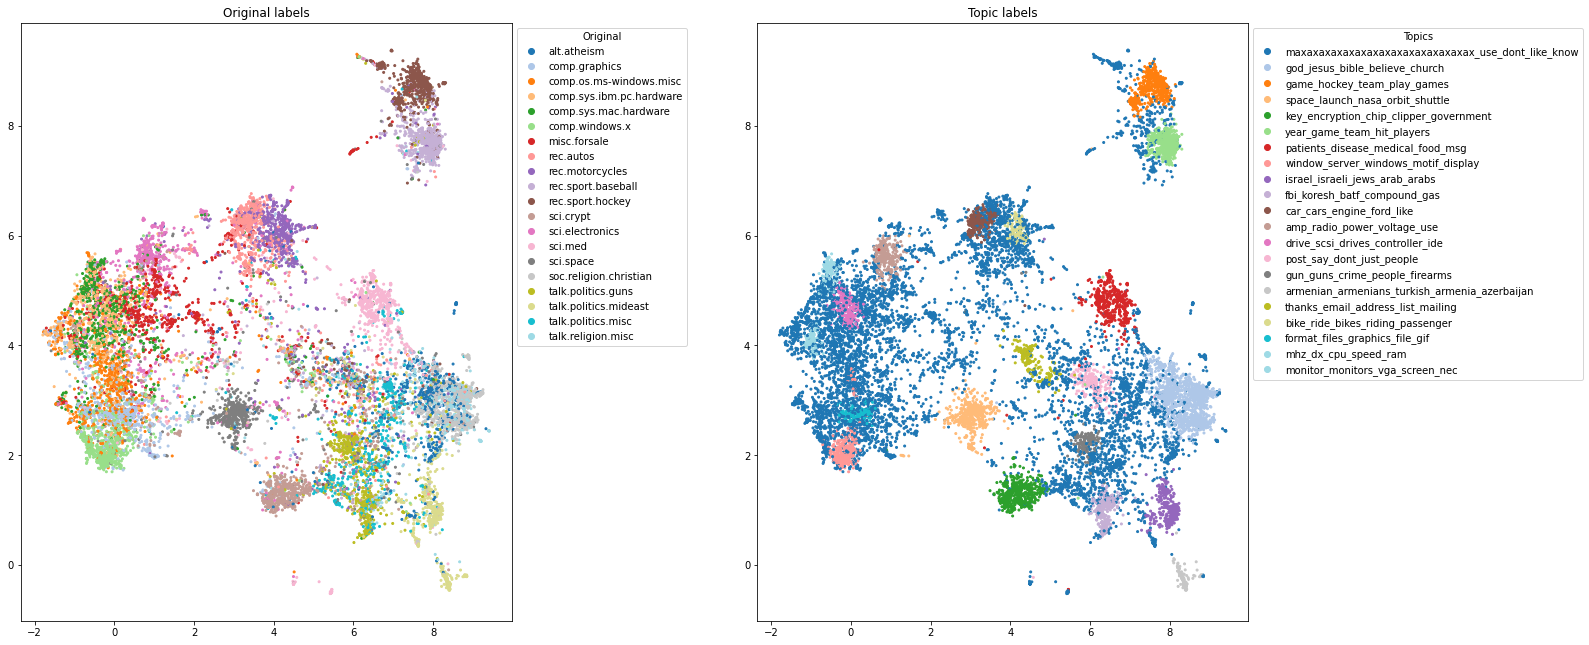

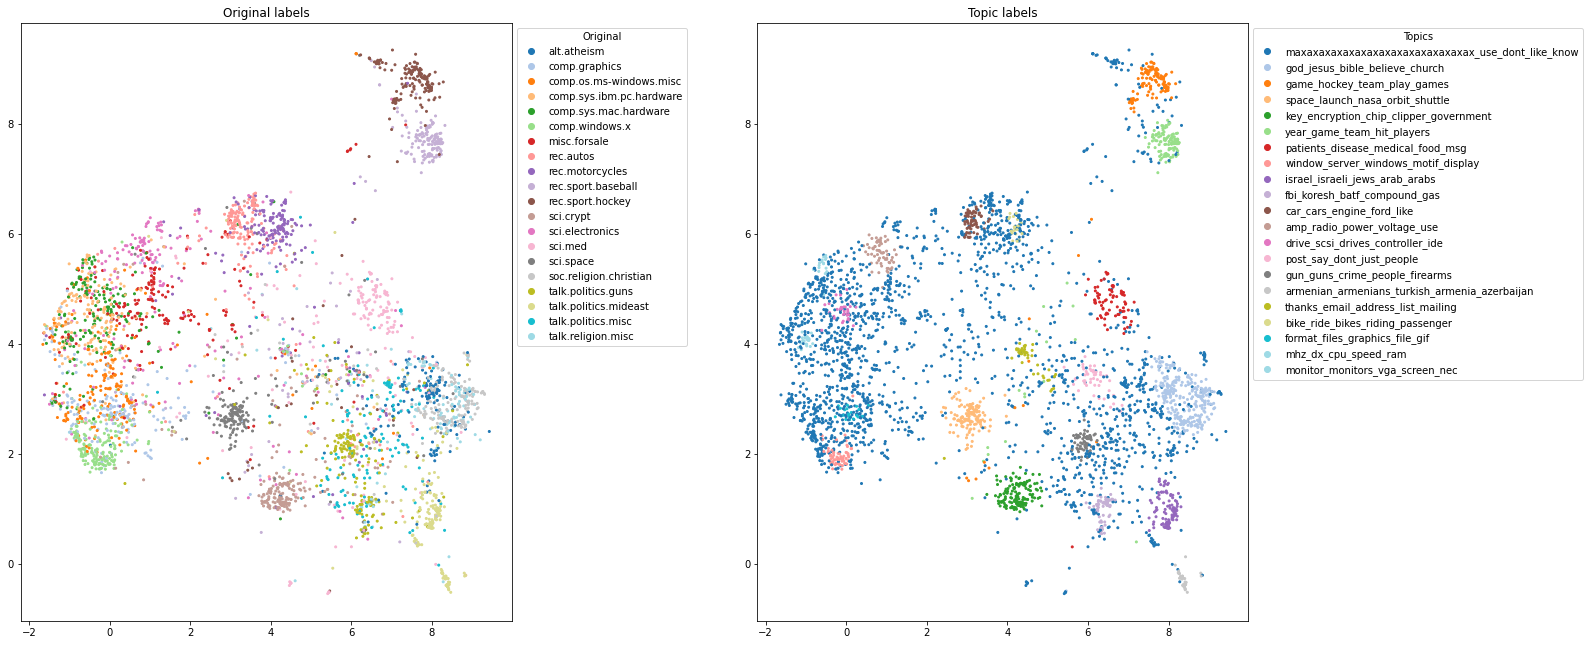

In [9]:
best_run = mlflow.search_runs(filter_string="tags.mlflow.runName = 'best-model'")

if best_run.shape[0] == 0:
    # Set up best trial object
    params = top_result[top_result.index.str.contains('params.')].dropna().sort_index().to_dict()
    dtypes = [float, str, int, str, str, int, int, int, int, str]
    params = {k.split('.')[1]: t(v) for (k, v), t in zip(params.items(), dtypes)}
    distributions = [
        LogUniformDistribution(0.01, 1.0),
        CategoricalDistribution(['eom', 'leaf']),
        CategoricalDistribution([5]),
        CategoricalDistribution(['doc2vec', 'sentence-transformers/msmarco-distilbert-base-v4']),
        CategoricalDistribution(['cosine', 'euclidean']),
        IntUniformDistribution(30, 150),
        IntUniformDistribution(10, 60),
        CategoricalDistribution([2, 5, 10, 25, 50]),
        IntUniformDistribution(10,50),
        CategoricalDistribution(['BERTopic', 'CTM', 'LDA'])
    ]
    best_trial = create_trial(
        value = top_result['metrics.minmax_avg'],
        params = params,
        distributions = dict(zip(params.keys(), distributions))
    )
    
    # Train the best model to get additional outputs
    log_best_model(best_trial)

In [17]:
# Print best_run
best_run.T

,0
run_id,bb24cc6ea69f4303ad3add28168feee8
experiment_id,1
status,FINISHED
artifact_uri,/home/dsilva/projects/mapintel/experiments/../...
start_time,2021-12-16 23:25:03.763000+00:00
end_time,2021-12-16 23:28:46.818000+00:00
metrics.timer_top_model_train,25.775739
metrics.topic_diversity,0.87619
metrics.nmi_test,0.404129
metrics.umap_20nn_acc_train,0.442276


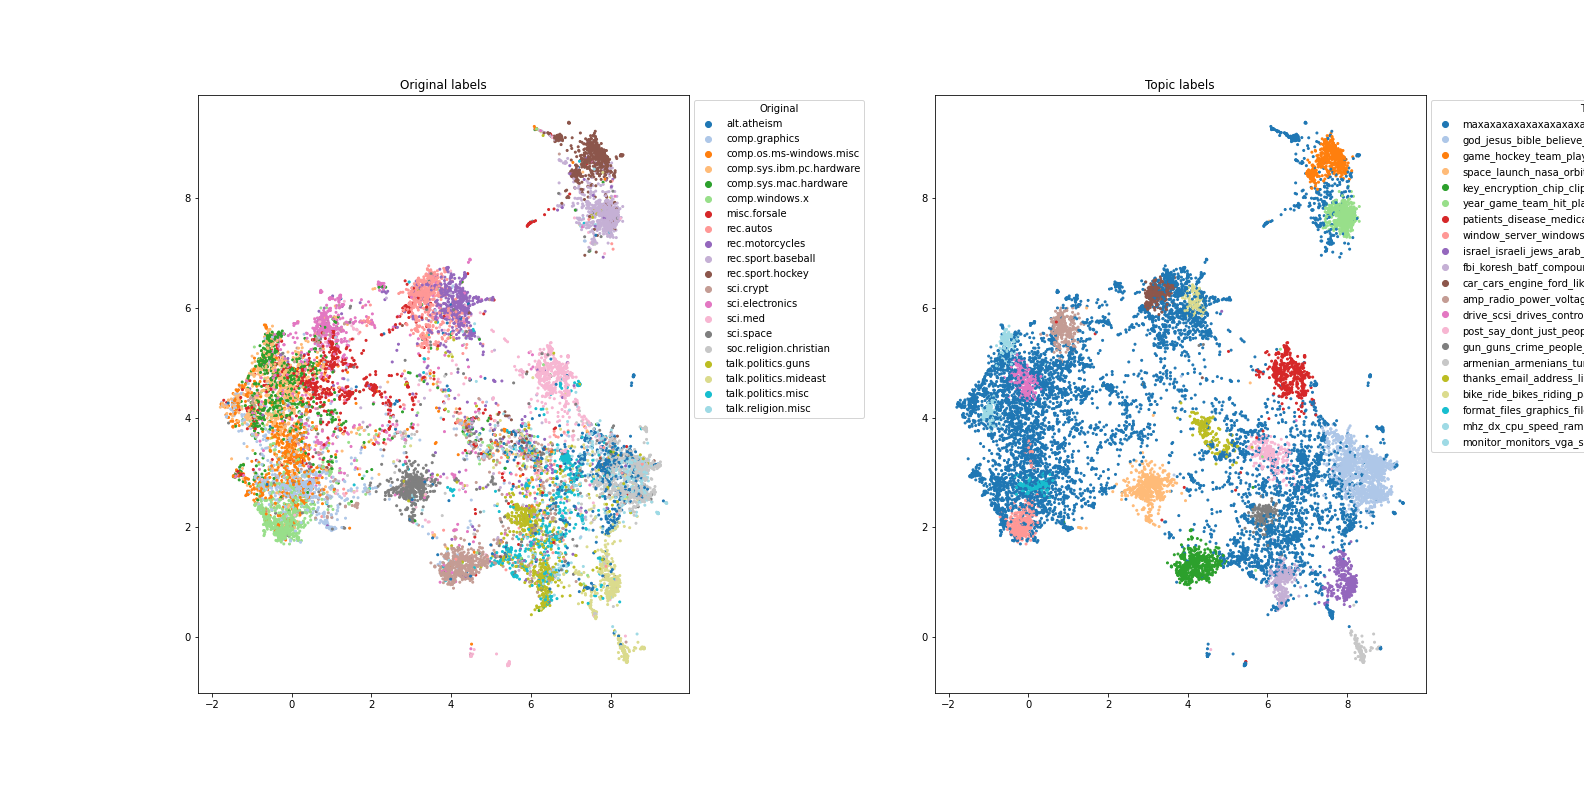

In [16]:
Image(os.path.join(best_run['artifact_uri'][0], 'umap_train_plot.png'))

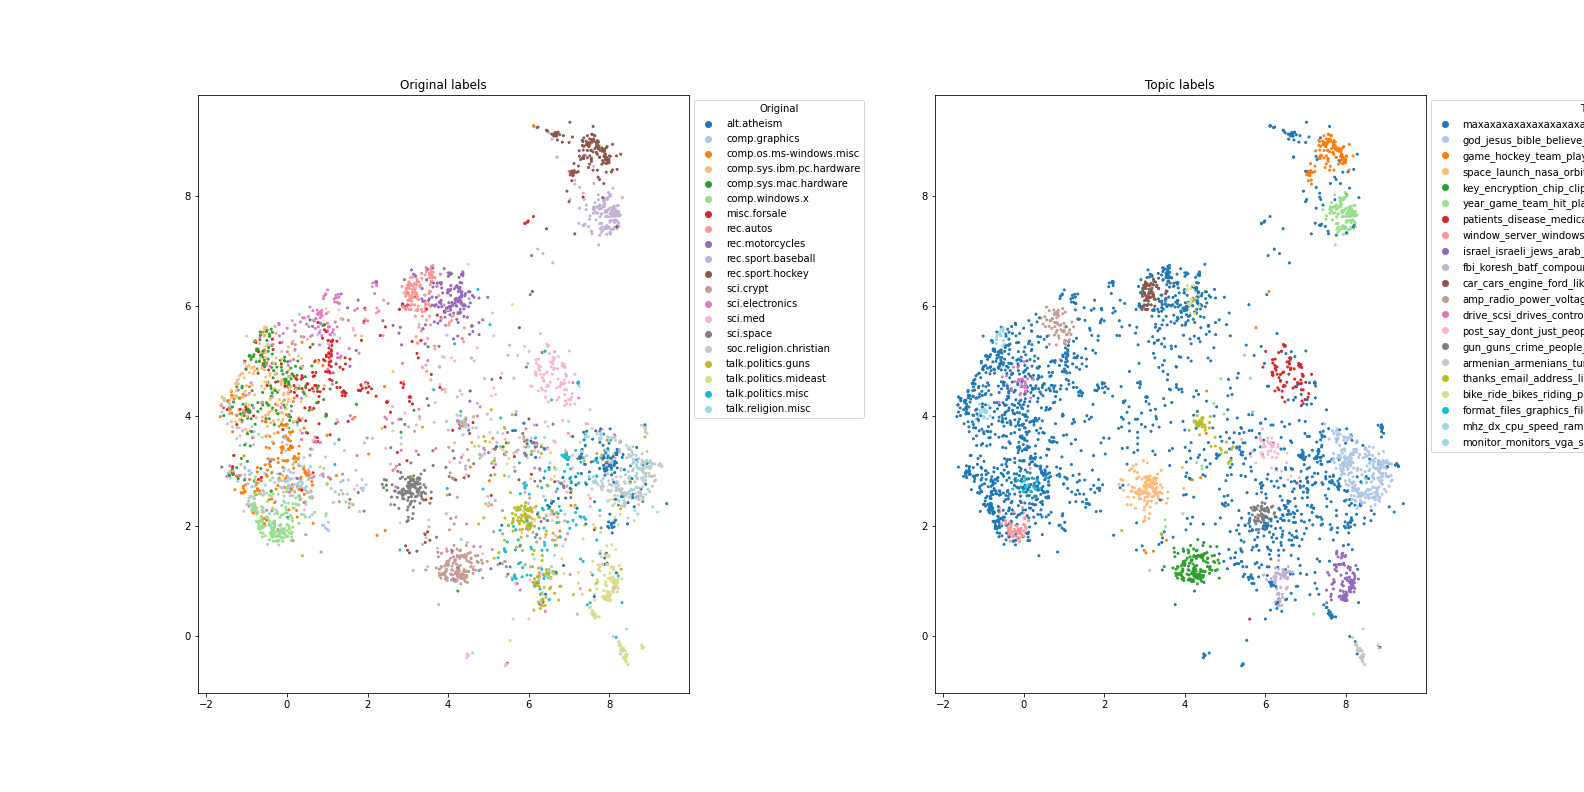

In [15]:
# Visualize artifacts from highest minmax_avg
Image(os.path.join(best_run['artifact_uri'][0], 'umap_test_plot.png'))